In [277]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [278]:
import numpy as np 
import pandas as pd 
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [280]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [281]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [282]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [283]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [284]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [285]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [287]:
# Find the most recent date in the data set.
most_recent_date_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = most_recent_date_row[0]  
print(f"Most Recent Date: {most_recent_date}")


Most Recent Date: 2017-08-23


Date One Year Ago: 2016-08-23


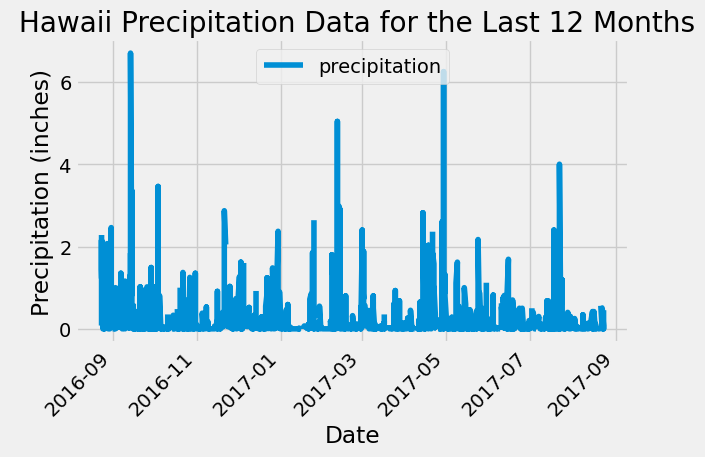

In [288]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.  
# Starting from the most recent data point in the database. 
most_recent_date = datetime.strptime('2017-08-23', '%Y-%m-%d')

# Calculate the date one year from the last date in data set. 
one_year_ago = most_recent_date - timedelta(days=365)
print(f"Date One Year Ago: {one_year_ago.strftime('%Y-%m-%d')}")

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_data_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Convert the 'date' column to datetime format
precipitation_data_df['date'] = pd.to_datetime(precipitation_data_df['date'])

# Sort the dataframe by date
precipitation_data_df.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_data_df.plot(x='date', y='precipitation', rot=90)

plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title(' Hawaii Precipitation Data for the Last 12 Months')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(loc='upper center')
plt.savefig("precipitation_data.png")
plt.show()


In [289]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_data_df.describe()


,date,precipitation
count,2223,2015.000000
mean,2017-02-16 18:54:53.927125248,0.176462
min,2016-08-24 00:00:00,0.000000
25%,2016-11-19 00:00:00,0.000000
50%,2017-02-15 00:00:00,0.020000
75%,2017-05-17 00:00:00,0.130000
max,2017-08-23 00:00:00,6.700000
std,NaN,0.460288


# Exploratory Station Analysis

In [291]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).distinct().count()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [292]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station,
    func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [293]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0] 

# Perform a query to calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station_id).all()

# Unpack the results
min_temp, max_temp, avg_temp = temperature_stats[0]


temperature_stats

[(54.0, 85.0, 71.66378066378067)]

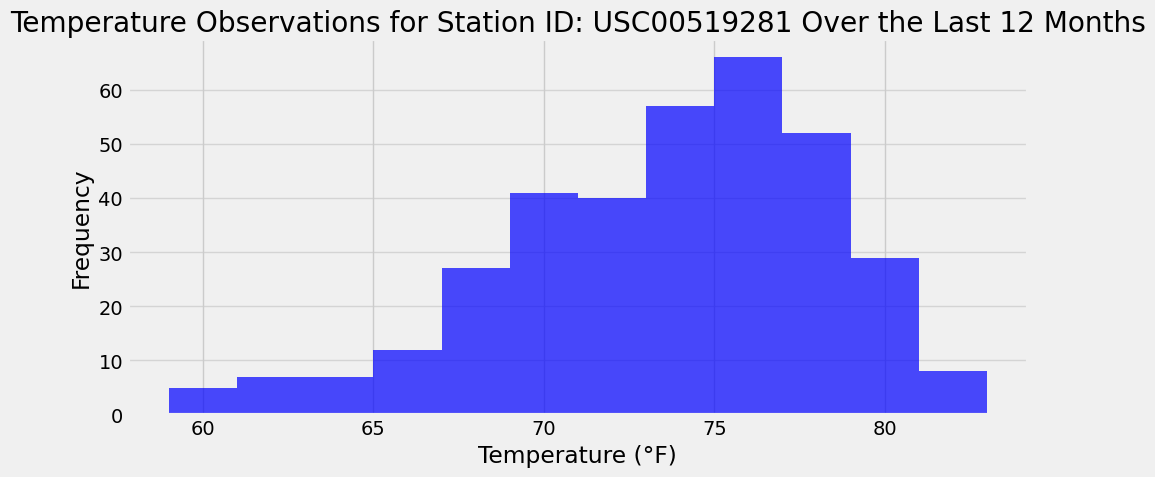

In [294]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Convert the query results to a list of temperatures
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(10, 5))
plt.hist(temperatures, bins=12, color='blue', alpha=0.7)  
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station ID: {most_active_station_id} Over the Last 12 Months')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.savefig("temperature_histogram.png") 
plt.show()  


# Close Session

In [296]:
# Close Session
session.close()